## 2.5 Numerical Simulation with respect to fBm

#### 2.5.1 Cholesky-based simulation methods----Computation Time vs step size $N$ 

Computation Time vs step size $N$ for Cholesky fBm Simulation

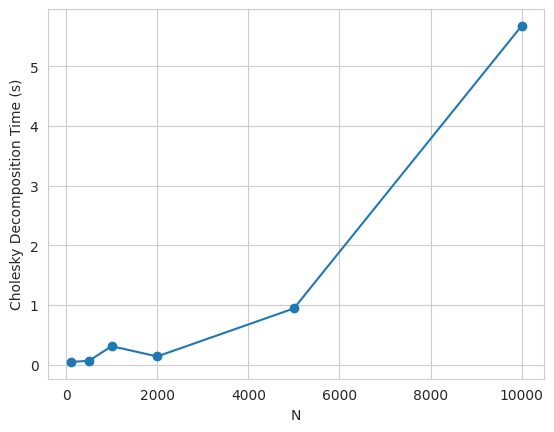

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
import seaborn as sns

sns.set_style("whitegrid")

def benchmark_cholesky(H, N_values, T=1.0):
    times = []
    for N in N_values:
        try:
            t = np.linspace(0, T, N+1)
            C = np.zeros((N+1, N+1))
            for i in range(N+1):
                for j in range(N+1):
                    C[i, j] = 0.5 * (t[i]**(2*H) + t[j]**(2*H) - abs(t[i]-t[j])**(2*H))
            C += 1e-10 * np.eye(N+1)
            start = time.time()
            cholesky(C, lower=True)
            duration = time.time() - start
            times.append(duration)
        except:
            times.append(np.nan)
            print(f"Failed at N = {N}")
    return times

N_values = [100, 500, 1000, 2000, 5000, 10000]
H = 0.7
times = benchmark_cholesky(H, N_values)
plt.plot(N_values, times, 'o-')
plt.xlabel("N")
plt.ylabel("Cholesky Decomposition Time (s)")
# plt.title("Computation Time vs N for Cholesky fBm Simulation")
plt.grid(True)
plt.show()

Computation Time Comparison: Direct vs fGn-based Cholesky

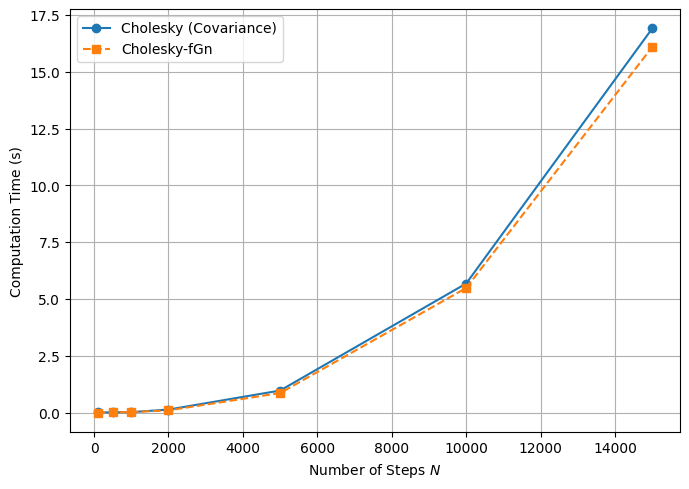

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

def cholesky_direct(H, N, T=1.0):
    t = np.linspace(0, T, N + 1)
    C = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(N + 1):
            C[i, j] = 0.5 * (t[i] ** (2 * H) + t[j] ** (2 * H) - abs(t[i] - t[j]) ** (2 * H))
    C += 1e-10 * np.eye(N + 1)
    start = time.time()
    L = cholesky(C, lower=True)
    Z = np.random.randn(N + 1)
    B = L @ Z
    return time.time() - start

def cholesky_fgn(H, N, T=1.0):
    def gamma(k):
        return 0.5 * (abs(k + 1) ** (2 * H) + abs(k - 1) ** (2 * H) - 2 * abs(k) ** (2 * H))
    
    Gamma = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            Gamma[i, j] = gamma(i - j)
    Gamma += 1e-10 * np.eye(N)
    
    start = time.time()
    L = cholesky(Gamma, lower=True)
    Z = np.random.randn(N)
    fGn = L @ Z
    fGn *= (T / N) ** H
    B = np.zeros(N + 1)
    B[1:] = np.cumsum(fGn)
    return time.time() - start

# Benchmark
N_values = [100, 500, 1000, 2000, 5000, 10000, 15000]
H = 0.7
time_direct = []
time_fgn = []

for N in N_values:
    time_direct.append(cholesky_direct(H, N))
    time_fgn.append(cholesky_fgn(H, N))

# Plot
plt.figure(figsize=(7, 5))
plt.plot(N_values, time_direct, 'o-', label='Cholesky (Covariance)')
plt.plot(N_values, time_fgn, 's--', label='Cholesky-fGn')
plt.xlabel('Number of Steps $N$')
plt.ylabel('Computation Time (s)')
# plt.title('Computation Time Comparison: Direct vs fGn-based Cholesky')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2.5.2 Spectral simulation: Davies–Harte method

Computation Time vs step size $N$ for Davies–Harte fBm Simulation

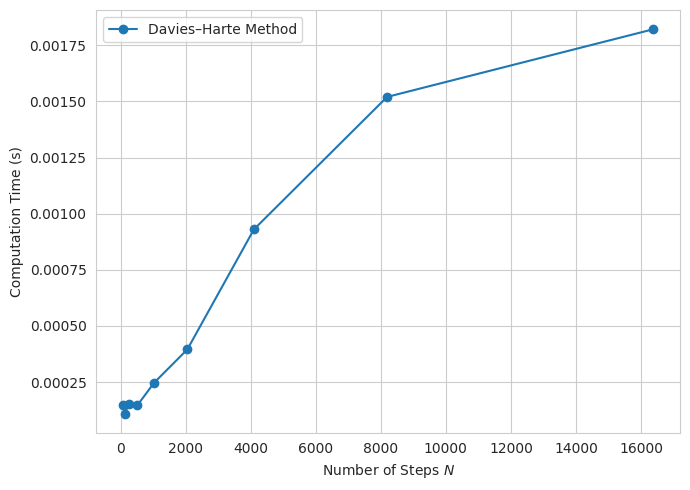

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

sns.set_style("whitegrid")

# Define Lambda function for Davies-Harte method
def Lambda(H, N):
    M = 2 * N - 2
    G = 2 * H
    n = np.arange(0, N)
    fbc = lambda n: ((n + 1) ** G + np.abs(n - 1) ** G - 2 * n ** G) / 2
    C = np.zeros(M)
    C[:N] = fbc(n)
    C[N:] = C[1:N-1][::-1]
    res = np.real(np.fft.fft(C)) ** 0.5
    return res

# Generate fGn using fixed Gaussian vector Z
def FGN_with_fixed_Z(Z, lambdas):
    A = np.fft.ifft(Z, axis=0) * lambdas
    res = np.fft.fft(A, axis=0)
    return np.real(res[:len(lambdas)//2])

# Benchmark Davies-Harte method
def benchmark_davies_harte(H=0.7, N_list=None):
    if N_list is None:
        N_list = [2**i + 1 for i in range(6, 15)]  # From 2^6+1 to 2^14+1

    times = []
    for N in N_list:
        M = 2 * N - 2
        Z = np.random.randn(M)
        start = time.time()
        lambdas = Lambda(H, N)
        fgn_sample = FGN_with_fixed_Z(Z, lambdas)
        end = time.time()
        times.append(end - start)
    
    return N_list, times

# Run benchmark
N_list, times = benchmark_davies_harte()

# Plot with consistent Seaborn styling
plt.figure(figsize=(7, 5))
plt.plot(N_list, times, 'o-', label='Davies–Harte Method')
plt.xlabel('Number of Steps $N$')
plt.ylabel('Computation Time (s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Simulation paths of fBm for different H using Davies–Harte method

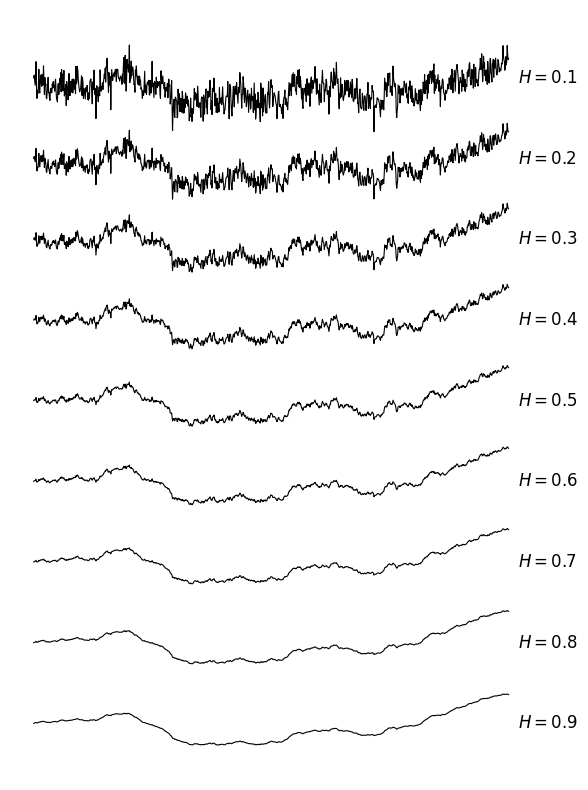

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def Lambda(H, N):
    """
    Compute the eigenvalues (lambda) for the Davies-Harte method,
    representing the spectral density of the fractional Brownian motion.
    """
    M = 2 * N - 2
    G = 2 * H
    n = np.arange(0, N)
    # Discrete autocovariance of fractional Gaussian noise
    fbc = lambda n: ((n + 1) ** G + np.abs(n - 1) ** G - 2 * n ** G) / 2
    C = np.zeros(M)
    C[:N] = fbc(n)
    C[N:] = C[1:N-1][::-1]  # Enforce symmetry
    res = np.real(np.fft.fft(C)) ** 0.5  # Take positive square root of FFT
    return res

def FGN_with_fixed_Z(Z, lambdas):
    """
    Generate a single sample of fractional Gaussian noise (fGn)
    using a fixed Gaussian vector Z shared across all H,
    ensuring consistent trends in different H simulations.
    """
    A = np.fft.ifft(Z, axis=0) * lambdas
    res = np.fft.fft(A, axis=0)
    res = np.real(res[:len(lambdas)//2])  # Take real part of first half
    return res

def fBm_from_fGn(fgn_sample, T=1.0, H=0.7):
    """
    Integrate fGn sample to obtain fractional Brownian motion (fBm) sample path.
    """
    N = len(fgn_sample)
    scale = (T / N) ** H  # Scale increments to match time and Hurst parameter
    fgn_scaled = fgn_sample * scale
    fbm_sample = np.cumsum(fgn_scaled)  # Cumulative sum -> fBm path
    return fbm_sample

def plot_fbm_fixed_noise(H_list, N=2**10 + 1, T=1.0):
    """
    Generate and plot fBm paths for multiple H using the same noise sequence,
    so that only H influences path smoothness but not overall trend.
    """
    np.random.seed(2024)  # Fixed seed for reproducibility
    M = 2 * N - 2

    Z = np.random.randn(M)  # Generate one Gaussian sequence shared for all H
    plt.figure(figsize=(6, 8))
    spacing = 6
    t = np.linspace(0, T, N-1)  # Time vector aligned with fBm sample length

    for i, H in enumerate(H_list):
        lambdas = Lambda(H, N)
        fgn_sample = FGN_with_fixed_Z(Z, lambdas)
        fbm_sample = fBm_from_fGn(fgn_sample, T=T, H=H)
        fbm_sample -= fbm_sample[0]  # Shift to start at zero
        fbm_sample /= np.std(fbm_sample)  # Normalize to comparable amplitude
        offset = (len(H_list) - i - 1) * spacing  # Vertical offset for plotting
        plt.plot(t, fbm_sample + offset, 'k', linewidth=0.8)
        plt.text(T + 0.02, offset, f'$H={H:.1f}$', fontsize=12, va='center')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and plot
plot_fbm_fixed_noise([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])